# A Spam Filter with Naive Bayes

## Introduction

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the The UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection 'here'). You can also download the dataset directly from this link. The data collection process is described in more details on this page, where you can also find some of the authors' papers.

## Project Goal

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 90% — so we expect that more than 90% of the new messages will be classified correctly as spam or ham (non-spam).

## Import useful libraries for this project

In [1]:
# import all 'libraries' required for this project.
import pandas as pd
import numpy as np
import random
from numpy.random import seed, randint
from IPython.display import HTML
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

In [2]:
# Load the data from csv file
messages_df = pd.read_csv('SMSSpamCollection', sep='\t', header=None)

In [3]:
# display first 5 rows of dataset
messages_df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# set the columns
messages_df.columns=['Label', 'SMS']

In [5]:
print(messages_df.info(), '\n')

print(messages_df['Label'].value_counts(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None 

ham     4825
spam     747
Name: Label, dtype: int64 



In [6]:
print('The total number of messages are:', len(messages_df), '\n')

The total number of messages are: 5572 



In [7]:
ham = messages_df[messages_df['Label'] == 'ham']
spam = messages_df[messages_df['Label'] == 'spam']

percent_ham = (100*len(ham))/len(messages_df)
percent_spam = 100 - percent_ham
print('The percentage of messages classified as ham are', "{:.2f}%".format(percent_ham), '\n')
print('The percentage of messages classified as spam are', "{:.2f}%".format(percent_spam))

The percentage of messages classified as ham are 86.59% 

The percentage of messages classified as spam are 13.41%


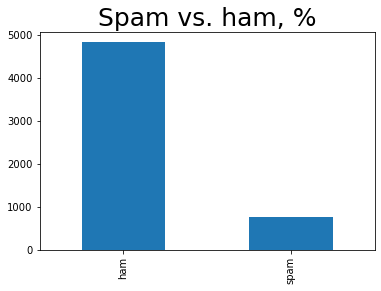

In [8]:
messages_df["Label"].value_counts().plot(kind = "bar")
plt.title('Spam vs. ham, %', fontsize=25);

## Training and Test Set
To start with, we have to put apart a portion of the entire dataset that we'll use at the end to test how well our spam filter classifies new messages. Hence, we have to split our dataset into 2 parts:

- a training set (80% of the dataset, i.e. 4,458 messages), which we'll use to train the computer how to classify messages,
- a test set (20% of the dataset, i.e. 1,114 messages), which we'll use for a final check.

Let's focus on creating a spam filter that classifies new messages with an accuracy greater than 80%. 
First, we're going to randomize the dataset to ensure that spam and ham messages are spread properly throughout the dataset.

In [9]:
sms_randomized = messages_df.sample(frac=1, random_state=1)

# Creating a training set (80%) and a test set (20%)
training_set = sms_randomized[:4458].reset_index(drop=True)
test_set = sms_randomized[4458:].reset_index(drop=True)

In [10]:
# for training set
spam_ham_pct = round(training_set['Label'].value_counts(normalize=True)*100, 0)
print(spam_ham_pct.to_markdown(tablefmt='pretty', headers=['Label', '%']))

+-------+------+
| Label |  %   |
+-------+------+
|  ham  | 87.0 |
| spam  | 13.0 |
+-------+------+


In [11]:
# for testing set
spam_ham_pct = round(test_set['Label'].value_counts(normalize=True)*100, 0)
print(spam_ham_pct.to_markdown(tablefmt='pretty', headers=['Label', '%']))

+-------+------+
| Label |  %   |
+-------+------+
|  ham  | 87.0 |
| spam  | 13.0 |
+-------+------+


## Data Cleaning
Let's perform some data cleaning to bring the data of the training set in a format that will allow us to extract easily all the necessary information. This format implies a table with the following features:

- the Label column (spam/ham), the SMS column, and a series of new columns, each representing a unique word from the vocabulary,
- each row describes a single message, with the number of times each word from the vocabulary occurs in it,
- all words in the vocabulary are in lower case,
- punctuation is not considered anymore.

### Letter Case and Punctuation

First, we'll remove the punctuation and bring all the words to lower case:


In [12]:
# Removing punctuation and making all the words lower case
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ').str.lower()
training_set.head()

C:\Users\mamun\AppData\Local\Temp/ipykernel_848/157107922.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ').str.lower()


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


#### Creating the Vocabulary
Next, we'll create a list of all the unique words that occur in the messages of our training set.

In [13]:
training_set['SMS'] = training_set['SMS'].str.split()
training_set.head(3)

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"


In [14]:
vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
vocabulary = list(set(vocabulary))
print(f'Number of unique words in the vocabulary of the training set: {len(vocabulary):,}')

Number of unique words in the vocabulary of the training set: 7,783


### The Final Training Set
The last step of data cleaning includes using the vocabulary to make the final data transformation to our training set:

In [15]:
# Creating a dictionary where each key is a unique word from the vocabulary,
# and each value is a list of the frequencies of that word in each message
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index]+=1
        
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head(3)

,avenue,carlos,engalnd,449050000301,escape,hmv,80878,jeetey,buz,devils,...,gaps,02085076972,rto,440,concentration,sory,satisfied,8714714,measure,enc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
training_set_final = pd.concat([training_set, word_counts], axis=1)
training_set_final.head(3)

,Label,SMS,avenue,carlos,engalnd,449050000301,escape,hmv,80878,jeetey,...,gaps,02085076972,rto,440,concentration,sory,satisfied,8714714,measure,enc
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Spam and not spam percent, total quantity, vocabulary from final training set

In [17]:
spam_sms = training_set_final[training_set_final['Label']=='spam']
ham_sms = training_set_final[training_set_final['Label']=='ham']


In [18]:
# P(Spam) and P(Ham)
p_spam = len(spam_sms) / len(training_set_final)
p_ham = len(ham_sms) / len(training_set_final)
print(p_ham)
print(p_spam)

0.8654104979811574
0.13458950201884254


In [19]:
# N_Spam
n_words_per_spam_message = spam_sms['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

print("spam : " ,n_spam)
# N_Ham
n_words_per_ham_message = ham_sms['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

print("non-spam", n_ham)

spam :  15190
non-spam 57237


In [20]:
# N_Vocabulary
n_vocabulary = len(vocabulary)

print(n_vocabulary)
# place smoothing
alpha = 1

7783


## setting parameters for training data and testing later on

In [21]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}


In [22]:
# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_sms[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_sms[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## Define a function for testing new message

In [23]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [24]:
classify('You\'ve been chosen a winner. Click on the number below to access your money.')

P(Spam|message): 2.8315919285309357e-41
P(Ham|message): 4.8489134175154895e-43
Label: Spam


In [25]:
classify('Hey Bill, let\'s celebrate your lottery win')

P(Spam|message): 2.1089565882319516e-24
P(Ham|message): 6.39163178120979e-23
Label: Ham


## Test the Spam Filter on test data set

In [26]:
def classify_test_df(message):    
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

### Predict the test data and check with actual data

In [27]:
pd.reset_option("display.max_columns")
test_set['predicted'] = test_set['SMS'].apply(classify_test_df)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


### Check the accuracy of spam filter

In [28]:
correct = 0
total = test_set.shape[0]
    
for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


## Conclusion

The spam filter developed by using Multinomial Naive Bayes in this case is very reliable at 98.74%.